In [10]:
import numpy as np
from random import shuffle
from scipy.stats import entropy
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import nashpy as nash
import random
import time
import open_spiel
import pyspiel
from open_spiel.python.algorithms import lp_solver

In [11]:
"""
Row player max, col player min
"""

'\nRow player max, col player min\n'

In [12]:
def get_br_to_strat(strat, payoffs, strat_is_row=True, verbose=False, random=False):
    if strat_is_row:
        weighted_payouts = strat@payoffs
        if random:
            weighted_payouts += np.random.rand(weighted_payouts.shape[0])/200
        if verbose:
            print("strat ", strat)
            print("weighted payouts ", weighted_payouts)
        
        br = np.zeros_like(weighted_payouts)
        br[np.argmin(weighted_payouts)] = 1
        idx = np.argmin(weighted_payouts)
    else:
        weighted_payouts = payoffs@strat.T
        if random:
            weighted_payouts += np.random.rand(weighted_payouts.shape[0])/200
        if verbose:
            print("strat ", strat)
            print("weighted payouts ", weighted_payouts)
            
        br = np.zeros_like(weighted_payouts)
        br[np.argmax(weighted_payouts)] = 1
        idx = np.argmax(weighted_payouts)
    return br, idx

In [13]:
def fictitious_play(payoffs, iters=2000, verbose=False):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    col_averages = col_pop
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
        row_average = np.average(row_pop, axis=0)
        col_average = np.average(col_pop, axis=0)
   
        row_br, idx = get_br_to_strat(col_average, payoffs, strat_is_row=False, verbose=False) 
        col_br, idx = get_br_to_strat(row_average, payoffs, strat_is_row=True, verbose=False)
        
        exp1 = row_average@payoffs@col_br.T
        exp2 = row_br@payoffs@col_average.T
        exps.append(exp2-exp1)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)        
        if verbose:
            print(exps[-1], "exploitability")
        
        row_averages = np.vstack((row_averages, row_average))
        col_averages = np.vstack((col_averages, col_average))
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
    return row_averages, col_averages, exps, times 

In [14]:
def get_exploitability(row_pop, col_pop, payoffs, iters=1000):
    emp_game_matrix = row_pop@payoffs@col_pop.T
    row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=iters)
    row_strat = row_averages[-1]@row_pop
    col_br, idx = get_br_to_strat(row_strat, payoffs=payoffs, strat_is_row=True)
    col_strat = col_averages[-1]@col_pop
    row_br, idx = get_br_to_strat(col_strat, payoffs=payoffs, strat_is_row=False)
    exp1 = row_strat@payoffs@col_br.T
    exp2 = row_br@payoffs@col_strat
    return exp2 - exp1

In [15]:
def double_oracle(payoffs, iters=2000, custom_row_strat=np.array([0]), custom_col_strat=np.array([0]), random=False):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    if custom_row_strat.any():
        row_pop = custom_row_strat
#     print(row_pop, "row pop")
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    if custom_col_strat.any():
        col_pop = custom_col_strat
#     print(col_pop, "col pop")
    col_averages = col_pop
    row_indices = []
    col_indices = []
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
#         print("Iteration: ", i+1)
        emp_game_matrix = row_pop@payoffs@col_pop.T
        row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=3000)
        nash_prob_1, nash_prob_2, _, _ = lp_solver.solve_zero_sum_matrix_game(
            pyspiel.create_matrix_game(emp_game_matrix, -emp_game_matrix))
        norm_pos1 = abs(nash_prob_1) / sum(abs(nash_prob_1))
        norm_pos2 = abs(nash_prob_2) / sum(abs(nash_prob_2))
        row_nash = np.reshape(np.array(norm_pos1), (np.array(norm_pos1).shape[0],)) 
        col_nash = np.reshape(np.array(norm_pos2), (np.array(norm_pos2).shape[0],))
               
#         row_strat = row_averages[-1]@row_pop
#         col_strat = col_averages[-1]@col_pop       
        row_strat = row_nash@row_pop
        col_strat = col_nash@col_pop
    
        row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=random) 
        col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=random)
        
#         print("Row Index: ", row_idx+1)
#         print("Column Index: ", col_idx+1)        

        if row_idx in row_indices and col_idx in col_indices:
#             print(row_indices, col_indices)
#             print('num iters do: ', i)
            return row_pop, col_pop, row_strat, col_strat, exps, times, row_indices, col_indices
        row_indices.append(row_idx)
        col_indices.append(col_idx)
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
        
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        exp = get_exploitability(row_pop, col_pop, payoffs)
        exps.append(exp)

    return row_pop, col_pop, row_strat, col_strat, exps, times, row_indices, col_indices      


In [16]:
def combine_two_payoffs(payoff1, payoff2):
    rows = payoff1.shape[0]
    cols = payoff1.shape[1]
    new_payoffs = np.zeros((rows**2, cols*2))
    for row1 in range(rows):
        for row2 in range(rows):
            for col in range(cols):
                new_payoffs[rows*row1 + row2, col] = payoff1[row1, col]
            for col in range(cols):
                new_payoffs[rows*row1 + row2, cols + col] = payoff2[row2, col]
    return new_payoffs

In [17]:
def phantom(payoff1, payoff2):
    rows = payoff1.shape[0]
    cols = payoff1.shape[1]
    new_payoffs = np.zeros((rows**2, cols**2))
    for row1 in range(rows):
        for row2 in range(rows):
            for col1 in range(cols):
                for col2 in range(cols):
                    new_payoffs[rows*row1 + row2, cols*col1 + col2] = payoff1[row1, col1] + payoff2[row2, col2]
    return new_payoffs

In [19]:
num_exps = 200
RPS = np.array([[0,-1,1],[1,0,-1],[-1,1,0]])

payoffs = combine_two_payoffs(RPS, RPS)
print(payoffs)

num_row_strats_list = []
num_col_strats_list = []
for i in range(num_exps):
    _, _, _, _, _, _, row_indices, col_indices = double_oracle(payoffs, random=False)
    num_row_strats = len(list(set(row_indices)))
    num_col_strats = len(list(set(col_indices)))
    num_row_strats_list.append(num_row_strats)
    num_col_strats_list.append(num_col_strats)
    print('iter: ', i)
    print(num_row_strats, 'row')
    print(num_col_strats, 'col')

[[ 0. -1.  1.  0. -1.  1.]
 [ 0. -1.  1.  1.  0. -1.]
 [ 0. -1.  1. -1.  1.  0.]
 [ 1.  0. -1.  0. -1.  1.]
 [ 1.  0. -1.  1.  0. -1.]
 [ 1.  0. -1. -1.  1.  0.]
 [-1.  1.  0.  0. -1.  1.]
 [-1.  1.  0.  1.  0. -1.]
 [-1.  1.  0. -1.  1.  0.]]
iter:  0
9 row
6 col
iter:  1
9 row
6 col
iter:  2
7 row
6 col
iter:  3
8 row
6 col
iter:  4
9 row
6 col
iter:  5
8 row
6 col
iter:  6
8 row
6 col
iter:  7
8 row
6 col
iter:  8
9 row
6 col
iter:  9
9 row
6 col
iter:  10
9 row
6 col
iter:  11
9 row
6 col
iter:  12
9 row
6 col
iter:  13
9 row
6 col
iter:  14
8 row
6 col
iter:  15
9 row
6 col
iter:  16
7 row
6 col
iter:  17
8 row
6 col
iter:  18
6 row
6 col
iter:  19
8 row
6 col


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  2., 17.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

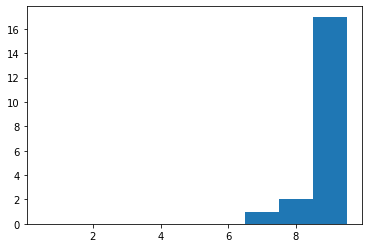

In [20]:
plt.hist(num_row_strats_list[:150], bins=[i for i in range(10)], align='right', )

(array([ 0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

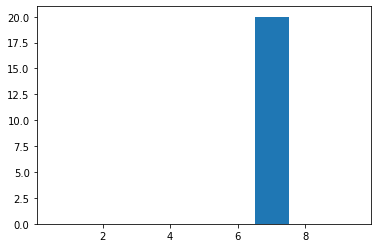

In [21]:
plt.hist(num_col_strats_list[:150], bins=[i for i in range(10)], align='right', )